# Installing Packages


In [1]:
using Plots, Statistics, FinancialToolbox, Dates
using Random, DiffEqBase.EnsembleAnalysis, Flux, Optimization, OptimizationFlux, DiffEqFlux, StochasticDiffEq, SciMLBase.EnsembleAnalysis
Random.seed!(1)

TaskLocalRNG()

# Geometric Brownian Motion 
Specifying the parameters for the GBM we wish to approximate with our neural SDE, and defining the GBM. 
$dS_t = rS_tdt + \sigma S_tdW_t$ <br>
$dS_t = rS_tdt + \sigma S_tdW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 20\%$ <br>

In [2]:
S₀ = Float32[100.]  # Initial value of the SDE.
r = 0.08 # Risk-free rate of interest.
σ = 0.2 # Volatility. 
datasize = 30 # The size of the solution/stock paths we want to calculate. 
tspan = (0.0f0, 1.0f0) # The time horizon we wish to obtain the stock path over. 
tsteps = range(tspan[1], tspan[2], length = datasize) # Each time step we want a stock price. 


function GBM_Drift(du, S, p, t) # Drift function of GBM. 
    du .= r*S
end


function GBM_Diffusion(du, S, p, t) # Diffusion function of GBM. 
    du .= σ*S
end

GBM = SDEProblem(GBM_Drift, GBM_Diffusion, S₀, tspan) # Specifying the GBM. 

SDEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 1.0f0)
u0: 1-element Vector{Float32}:
 100.0

# Training Data
We generate training data from the GBM. We do this by using DifferentialEquations.jl's parallel ensemble interface to generate data from the average of 1,000,000 runs of the SDE, and calculate means and variances across the 1,000,000 runs, at each time step. 

In [115]:
# Don't need the simulation as GBM has a closed form. 
GBM_Means = S₀.*exp.(r.*tsteps)

GBM_Vars = S₀.^(2).*exp.(2*r.*tsteps).*(exp.(σ.^(2)*tsteps).-1)

GBM_Means = hcat(Float32.(GBM_Means))'

GBM_Vars = hcat(Float32.(GBM_Vars))'


1×30 adjoint(::Matrix{Float32}) with eltype Float32:
 0.0  13.879  27.9308  42.1571  …  421.449  440.385  459.541  478.919

# Neural SDE
We specify our neural SDE to apprximate the GBM. We then show how it compares to the GBM before any training.

In [554]:
# Pre training the drift coefficient
gridsize = 1000;
Func(x) = r*x;
X_Training = collect(range(0,stop=10,length=gridsize));
Y_Training = Func.(X_Training);

X_Testing = collect(range(0.01,stop=5,length=gridsize));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end

# Pre_NSDE_Drift = Flux.Chain(Flux.Dense(1,12,relu),Flux.Dense(12,1))
Pre_NSDE_Drift = Flux.Chain(Flux.Dense(1,1))

loss_drift(x, y) = Flux.mse(Pre_NSDE_Drift(x), y)
opt_drift = Descent(0.01)
ps = Flux.params(Pre_NSDE_Drift)

for epoch in 1:200 
    Flux.train!(loss_drift, ps, data, opt_drift);
end

plt3 = plot(X_Testing ,[Y_Testing Pre_NSDE_Drift(X_Testing')'],title="Drift Coefficient After Training",label=["GBM Drift Coefficient" "Neural Network"], xlabel = "S",ylabel = "Drift Coefficient"); # before training


In [485]:
p1, re1 = Flux.destructure(Pre_NSDE_Drift)

# Pre_NSDE_Diffusion = Flux.Chain(Flux.Dense(1,1)) # Neural SDE diffusion.
Q = 16
Pre_NSDE_Diffusion =  Flux.Chain(Flux.Dense(1,Q,elu),Flux.Dense(Q,Q,elu),Flux.Dense(Q,1,softplus))
p2, re2 = Flux.destructure(Pre_NSDE_Diffusion)

Pre_NSDE = NeuralDSDE(Pre_NSDE_Drift , Pre_NSDE_Diffusion, tspan, SOSRI(), saveat = tsteps, reltol = 1e-1, abstol = 1e-1) # Specifying the neural SDE.

NeuralDSDE()

In [563]:
# Get the prediction using the correct initial condition
prediction0 = Pre_NSDE(S₀) # Get a prediction using our untrained neural SDE, but with the correct initial condition.

NSDE_Drift(u, p, t) = re1(p[1:Pre_NSDE.len])(u)
NSDE_Diffusion(u, p, t) = re2(p[Pre_NSDE.len+1:end])(u) # i.e. NSDE.len = 151, and there are 153 parameters, so we need to take the last two. 

NSDE = SDEProblem(NSDE_Drift, NSDE_Diffusion, S₀,(0.0f0, 1.0f0), Pre_NSDE.p) # Form the neural SDE into an SDE so it can be solved. Taking the parameters from the neural SDE. 

NSDE_ensemble_nprob = EnsembleProblem(NSDE)
NSDE_ensemble_nsol = solve(NSDE_ensemble_nprob, SOSRI(), trajectories = 10000, saveat = tsteps) # Simulating many paths. 
NSDE_ensemble_nsum = EnsembleSummary(NSDE_ensemble_nsol) # Taking means and varaince of the simulated paths. 

plt1 = plot(NSDE_ensemble_nsum, title = "Neural SDE: Before Training") # Plotting the neural SDE means and variances before training. 
scatter!(plt1, tsteps, GBM_Means',yerror = GBM_Vars', xlabel = "Time" , ylabel = "Share Price") # Plotting the GBM means.  

scatter(tsteps, prediction0[1,:], label = "Prediction");
scatter!(tsteps, GBM_Means', label = "Data",title = "Neural SDE Prediction Before Training", xlabel = "Time" , ylabel = "Share Price");


In [487]:
m_before,v_before = timeseries_steps_meanvar(NSDE_ensemble_nsol)
m_before = m_before[:,:]
v_before = v_before[:,:]

1×30 Matrix{Float32}:
 0.0  3.19651  6.51793  9.74516  …  97.8147  101.452  105.738  110.432

# Loss Function 
We define a loss function that calculates the mean and variance from n runs at each time point and uses the distance from the data values. It compares the GBM means and variances, to the neural SDE means and variances. This is training via moments matching.

In [318]:
function predict_neuralsde(p, u = S₀) 
  return Array(Pre_NSDE(u, p)) # Returns an array of stock prices/SDE solutions at each time point. 
end

function loss_neuralsde(p; n = 100)
  u = repeat(reshape(S₀, :, 1), 1, n) # Makes a 1 x n(100) matrix.
  samples = predict_neuralsde(p, u) # Takes n many random paths from the neural SDE, with the weights p. 
  means = mean(samples, dims = 2) # Takes the mean at each time point. 
  vars = var(samples, dims = 2, mean = means)[:, 1, :] # Computes the sample variance with known means at each time point. 
  means = means[:, 1, :] # Puts the means into a single vector. 
  loss = sum(abs2, GBM_Means - means) + sum(abs2, GBM_Vars - vars) # Our loss is the abs sum of the difference of means and variances. 
    return loss , means, vars
end

loss_neuralsde (generic function with 1 method)

In [319]:
list_plots = []
iter = 0
loss1 = zeros(1,1000)

# Callback function to observe training
callback = function (p, loss, means, vars; doplot = false)
  global list_plots, iter

  if iter == 0
    list_plots = []
  end
  iter += 1

  # loss against current data
  display(loss)
display(iter)
    loss1[iter] = loss

  # plot current prediction against data
  plt = Plots.scatter(tsteps, GBM_Means[1,:], yerror = GBM_Vars[1,:],
                     ylim = (-4.0, 8.0), label = "data")
  Plots.scatter!(plt, tsteps, means[1,:], ribbon = vars[1,:], label = "prediction")
  push!(list_plots, plt)

  if doplot
    display(plt)
  end
  return false
end

#144 (generic function with 1 method)

In [320]:
t1 = now()
opt = ADAM()

# First round of training with n = 10000
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=10000), adtype)
optprob = Optimization.OptimizationProblem(optf, Pre_NSDE.p)
result1 = Optimization.solve(optprob, opt, callback = callback, maxiters = 200)  # 200 iterations of training. 

2.14626f6

1

2.144834f6

2

2.141996f6

3

2.1371368f6

4

2.1296005f6

5

2.1185595f6

6

2.103895f6

7

2.0853018f6

8

2.058972f6

9

2.0283416f6

10

1.9930101f6

11

1.9517562f6

12

1.9006272f6

13

1.843265f6

14

1.7720629f6

15

1.7238044f6

16

1.6411788f6

17

1.554955f6

18

1.4608435f6

19

1.3690701f6

20

1.2445755f6

21

1.1469034f6

22

1.0789869f6

23

912637.8f0

24

803293.5f0

25

670968.25f0

26

599674.1f0

27

450784.66f0

28

383601.1f0

29

266143.44f0

30

206808.45f0

31

117054.484f0

32

56717.867f0

33

24292.87f0

34

5036.686f0

35

1327.761f0

36

33702.68f0

37

32772.555f0

38

64215.254f0

39

105057.51f0

40

176763.0f0

41

160996.16f0

42

111984.88f0

43

128153.62f0

44

73358.45f0

45

96644.734f0

46

79106.65f0

47

42842.23f0

48

17495.406f0

49

12132.811f0

50

1394.7122f0

51

2313.7588f0

52

2223.765f0

53

5571.888f0

54

8384.054f0

55

9089.145f0

56

23882.924f0

57

18120.533f0

58

22255.264f0

59

29776.51f0

60

19996.639f0

61

13224.856f0

62

24197.963f0

63

15848.647f0

64

14191.174f0

65

6642.9863f0

66

7073.278f0

67

3806.71f0

68

3056.8618f0

69

1261.6814f0

70

1662.3114f0

71

1325.4294f0

72

1363.1201f0

73

3470.095f0

74

7378.7275f0

75

7419.106f0

76

3607.1296f0

77

10369.418f0

78

4507.909f0

79

5102.7056f0

80

4466.9644f0

81

4585.453f0

82

591.42584f0

83

744.98456f0

84

696.0511f0

85

2050.8716f0

86

1298.2955f0

87

720.3361f0

88

1446.6915f0

89

2555.8608f0

90

2472.8108f0

91

1003.13306f0

92

751.50366f0

93

3058.236f0

94

4189.807f0

95

1328.3837f0

96

1249.8064f0

97

1619.9482f0

98

671.48926f0

99

657.33997f0

100

1502.0598f0

101

1714.3818f0

102

882.7934f0

103

899.34094f0

104

1105.0076f0

105

450.99707f0

106

1326.0806f0

107

743.5028f0

108

854.17847f0

109

967.52075f0

110

963.2876f0

111

1173.6049f0

112

2790.415f0

113

507.06464f0

114

840.45734f0

115

881.33527f0

116

1058.4987f0

117

745.7574f0

118

521.88855f0

119

388.4002f0

120

1298.9558f0

121

513.6398f0

122

1689.5077f0

123

643.3573f0

124

972.38635f0

125

769.2f0

126

1225.1074f0

127

1198.2576f0

128

747.8228f0

129

2159.2964f0

130

464.5108f0

131

872.67725f0

132

763.11755f0

133

496.9215f0

134

1007.9637f0

135

1351.1299f0

136

3821.8079f0

137

2374.2637f0

138

972.3431f0

139

1372.6132f0

140

383.401f0

141

1350.8878f0

142

2101.6064f0

143

1311.1656f0

144

1113.3656f0

145

1083.0587f0

146

1360.3306f0

147

1146.4452f0

148

858.57385f0

149

976.4999f0

150

1239.7726f0

151

822.7122f0

152

2165.1133f0

153

1772.2595f0

154

693.5359f0

155

1403.8828f0

156

800.14075f0

157

1858.4406f0

158

828.2637f0

159

1067.3918f0

160

751.364f0

161

1029.6493f0

162

876.2033f0

163

750.5022f0

164

535.72797f0

165

1283.9272f0

166

577.24896f0

167

468.59448f0

168

912.1375f0

169

646.05176f0

170

505.41296f0

171

1963.5924f0

172

1566.9889f0

173

1005.4474f0

174

740.31805f0

175

1293.9172f0

176

1838.315f0

177

636.46124f0

178

639.96893f0

179

978.58356f0

180

941.1561f0

181

1567.1605f0

182

2405.1255f0

183

654.2899f0

184

988.39056f0

185

1261.0177f0

186

597.8405f0

187

1183.9401f0

188

1028.4238f0

189

1114.6782f0

190

672.7747f0

191

2047.6984f0

192

1313.1985f0

193

723.6154f0

194

1099.4205f0

195

693.975f0

196

1752.6273f0

197

1410.7002f0

198

1309.7627f0

199

3769.5156f0

200

383.401f0

201

u: 323-element Vector{Float32}:
  0.10962975
  0.023349777
 -0.50908774
 -0.37795067
  0.029621009
 -0.2814438
 -0.27256417
 -0.031025795
  0.23690179
 -0.1806931
  0.017439652
  0.096771546
  0.0048444257
  ⋮
  0.28720486
  0.5570072
 -0.509563
  0.00042014578
 -0.28515375
  0.069747284
  0.0023114195
  0.31353244
 -0.15501942
  0.045051258
 -0.30358252
  0.03857558

In [323]:
t2 = now()
println(t2-t1)

5728359 milliseconds


In [321]:
t3 = now()

optf2 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=50000), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, result1.u)
result2 = Optimization.solve(optprob2, opt, callback = callback, maxiters = 300)
display(result2)

652.9772f0

202

5931.125f0

203

1115.6326f0

204

2671.5872f0

205

3224.1492f0

206

3150.6177f0

207

1011.2168f0

208

637.1466f0

209

612.6766f0

210

1146.261f0

211

2368.7693f0

212

612.2682f0

213

524.6729f0

214

720.1127f0

215

648.2628f0

216

1559.9767f0

217

1700.65f0

218

1112.9982f0

219

750.516f0

220

769.73676f0

221

1490.489f0

222

978.4032f0

223

1145.5132f0

224

649.8816f0

225

969.3995f0

226

945.4236f0

227

699.7631f0

228

665.9613f0

229

468.9742f0

230

826.3534f0

231

608.955f0

232

745.55383f0

233

581.8566f0

234

764.2923f0

235

898.8256f0

236

503.42297f0

237

575.9715f0

238

727.5681f0

239

873.0746f0

240

575.9939f0

241

471.03888f0

242

1090.6403f0

243

578.3883f0

244

624.8044f0

245

1165.7192f0

246

566.4835f0

247

403.51492f0

248

1350.5695f0

249

599.9026f0

250

1173.2356f0

251

430.37894f0

252

677.79224f0

253

871.88855f0

254

627.59845f0

255

741.61066f0

256

453.79633f0

257

1193.9324f0

258

420.58157f0

259

360.4167f0

260

444.9121f0

261

952.91125f0

262

834.6339f0

263

721.6702f0

264

507.64606f0

265

555.4969f0

266

752.06506f0

267

1087.5756f0

268

581.2391f0

269

400.44592f0

270

389.95102f0

271

766.3544f0

272

627.3032f0

273

944.03f0

274

745.09064f0

275

966.655f0

276

556.7434f0

277

2054.899f0

278

1010.5911f0

279

1123.4961f0

280

399.9517f0

281

548.6893f0

282

343.38263f0

283

348.76648f0

284

280.17548f0

285

398.20184f0

286

946.97235f0

287

551.6129f0

288

300.8883f0

289

532.9686f0

290

653.9724f0

291

470.1214f0

292

657.0597f0

293

566.8992f0

294

389.18915f0

295

515.00146f0

296

573.2907f0

297

632.97943f0

298

386.3418f0

299

735.0391f0

300

429.2583f0

301

386.9196f0

302

633.16907f0

303

335.2891f0

304

523.1472f0

305

621.91644f0

306

490.38422f0

307

454.26874f0

308

599.86865f0

309

467.78976f0

310

458.39624f0

311

611.3046f0

312

290.6715f0

313

403.688f0

314

305.3255f0

315

315.7617f0

316

350.74426f0

317

776.5712f0

318

412.2763f0

319

876.2851f0

320

404.38068f0

321

325.6805f0

322

264.806f0

323

530.57275f0

324

522.35645f0

325

297.93622f0

326

264.11664f0

327

444.84067f0

328

247.48114f0

329

537.85297f0

330

625.2606f0

331

223.61855f0

332

272.8925f0

333

334.76538f0

334

296.40796f0

335

256.12497f0

336

218.20857f0

337

222.44827f0

338

874.06116f0

339

950.82446f0

340

1382.2861f0

341

309.24823f0

342

292.97803f0

343

730.44904f0

344

812.4125f0

345

1136.217f0

346

664.7391f0

347

612.13794f0

348

1088.2147f0

349

2310.9646f0

350

723.3437f0

351

246.96486f0

352

1338.5634f0

353

542.92773f0

354

463.97842f0

355

258.9107f0

356

248.84535f0

357

567.04144f0

358

218.3187f0

359

340.85037f0

360

587.1113f0

361

291.26773f0

362

335.02878f0

363

545.4295f0

364

553.81323f0

365

829.4881f0

366

260.6415f0

367

500.95825f0

368

772.615f0

369

941.3648f0

370

321.04373f0

371

1371.3728f0

372

1498.3989f0

373

1395.5663f0

374

388.40393f0

375

963.2147f0

376

2955.9963f0

377

1029.2002f0

378

288.15433f0

379

411.11154f0

380

2906.924f0

381

2672.9346f0

382

1473.3823f0

383

497.7467f0

384

1127.3267f0

385

1040.5259f0

386

548.9209f0

387

247.75586f0

388

702.60535f0

389

306.61548f0

390

758.88684f0

391

270.5353f0

392

271.11642f0

393

274.24823f0

394

311.69177f0

395

295.7407f0

396

333.02798f0

397

320.06418f0

398

221.55118f0

399

195.7978f0

400

262.38885f0

401

277.21014f0

402

299.99255f0

403

268.94244f0

404

349.94614f0

405

486.4015f0

406

540.79034f0

407

253.23302f0

408

214.78398f0

409

243.48035f0

410

165.56897f0

411

401.70038f0

412

420.5305f0

413

918.64343f0

414

1204.008f0

415

1033.0492f0

416

209.60312f0

417

173.86676f0

418

1042.9329f0

419

208.50734f0

420

1080.3752f0

421

579.6901f0

422

365.3358f0

423

454.0308f0

424

380.02475f0

425

281.6117f0

426

464.19012f0

427

186.21364f0

428

1023.916f0

429

233.30669f0

430

475.1865f0

431

666.75397f0

432

916.9398f0

433

177.16649f0

434

354.22675f0

435

301.04654f0

436

1171.2837f0

437

451.66113f0

438

1122.3744f0

439

585.92114f0

440

305.12195f0

441

375.40262f0

442

348.60782f0

443

305.75787f0

444

465.95837f0

445

224.85652f0

446

313.41232f0

447

821.22394f0

448

1334.9646f0

449

246.7755f0

450

1001.3214f0

451

969.4605f0

452

442.7183f0

453

303.45724f0

454

299.11844f0

455

1176.6343f0

456

641.36426f0

457

255.6442f0

458

464.1646f0

459

261.29654f0

460

311.6023f0

461

263.28015f0

462

263.86572f0

463

198.16492f0

464

251.46696f0

465

264.86084f0

466

510.57666f0

467

344.93872f0

468

530.5036f0

469

1068.7931f0

470

1330.8754f0

471

510.6987f0

472

579.75653f0

473

454.9257f0

474

472.95654f0

475

308.81555f0

476

790.52277f0

477

570.54694f0

478

895.6461f0

479

1448.9677f0

480

251.41495f0

481

502.55783f0

482

1540.9106f0

483

611.43787f0

484

1485.0045f0

485

222.98122f0

486

281.30994f0

487

529.68066f0

488

334.2202f0

489

294.45078f0

490

352.9655f0

491

219.39229f0

492

241.17357f0

493

298.71664f0

494

465.95657f0

495

500.56915f0

496

300.59323f0

497

255.92786f0

498

280.92993f0

499

275.19385f0

500

544.6689f0

501

165.56897f0

502

u: 323-element Vector{Float32}:
  0.081610635
 -0.011877502
 -0.509174
 -0.3728465
  0.030100193
 -0.24636723
 -0.22132629
 -0.03577714
  0.2371394
 -0.16134727
  0.015077574
  0.096932665
  0.003071713
  ⋮
  0.28755283
  0.5571627
 -0.50849694
  0.00084437104
 -0.2871324
  0.07026042
 -7.2872994f-5
  0.31381053
 -0.15699793
  0.04307268
 -0.3055609
  0.04055416

In [322]:
#### Time taken to execute training
t4 = now()
println(t4-t3)

5224915 milliseconds


In [459]:
loss, means, vars = loss_neuralsde(result2.u, n = 100000)

plt2 = Plots.scatter(tsteps, GBM_Means', yerror = GBM_Vars',
                     label = "Data", title = "Neural SDE: After Training",
                     xlabel = "Time")
plot!(plt2, tsteps, means', lw = 3, ribbon = vars', label = "Prediction")
display(loss)
plt = plot(plt1, plt2, layout = (2 , 1))
#savefig(plt, "NN_sde_combined.pdf"); nothing # sde

244.39471f0

# Option Pricing
Pricing vanilla call options with the trained neural SDE, and comparing it to the Black-Scholes call prices for various strikes.

In [325]:
# Vanilla Call Price Function. 

function call_pricer(stock_price,K)
    A = stock_price-ones(size(stock_price))*K
    B = maximum([A zeros(size(A))],dims=2)
    Call_Price = exp(-r*tspan[2])*mean(B)
    return Call_Price
end 

call_pricer (generic function with 1 method)

In [354]:
# Generating 100,000 neural SDE stock paths.
prob = result2.u
u1 = repeat(reshape(S₀, :, 1), 1, 100000)
a = predict_neuralsde(prob, u1)[1,:,:]

stock_price_NSDE = a[:,end];

In [556]:
K = range(80, 120, length = 21)
NSDE_Price = zeros(1,length(K))
BS_Price = zeros(1,length(K))

for i in 1:length(K)
    BS_Price[i] = blsprice(100,K[i],r,tspan[2],σ,0.0)
    NSDE_Price[i] = call_pricer(stock_price_NSDE,K[i])
end 


plot(K,BS_Price',label = "Black-Scholes Call Price")
plt5 = plot!(K,NSDE_Price',title="Call Prices After Training",label = "Neural SDE Call Price After Training",xlabel = "Strike",ylabel = "Price");

# Comparing Implied Vol

In [557]:
BS_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    BS_Vol[i] = blsimpv(100,K[i],r,tspan[2],BS_Price[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_Price[i])
end 
plt19 = scatter(K,Vol_After',title="Call Prices",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
scatter(plt19)
plt11 = plot!(K,BS_Vol', linewidth=2,c=:red,title="Black & Scholes Implied Volatility",label = "Black-Scholes Implied Volatility");

In [357]:
prob2 = result2.u
a2 = predict_neuralsde(prob2, u1)[1,:,:]
stock_price_NSDE2 = a2[:,end]

100000-element Vector{Float32}:
 118.79631
  54.784187
 110.42041
 116.218895
 106.916565
 101.3009
  88.268616
  83.21676
  73.6527
 145.45479
 106.480446
 105.02754
  88.466286
   ⋮
 179.00447
 100.262215
  92.63883
 117.42249
  94.25648
 108.93898
  70.562325
 108.698364
 121.56935
  80.47787
 119.33035
 117.63076

In [358]:
prob1 = result1.u
a1 = predict_neuralsde(prob1, u1)[1,:,:]
stock_price_NSDE1 = a1[:,end]

100000-element Vector{Float32}:
 121.2053
  86.72464
  88.211266
  83.301186
 100.545525
  77.63068
 135.62949
 130.56387
 120.597046
  95.366646
 157.04727
 117.22765
 101.77317
   ⋮
  76.39592
 165.67459
  79.19372
  92.11416
 102.86772
 130.75134
 119.41333
 144.0679
  86.130196
 152.48839
  79.95301
 153.03992

In [359]:
NSDE_Price1 = zeros(1,length(K))
NSDE_Price2 = zeros(1,length(K))


for i in 1:length(K)
    NSDE_Price1[i] = call_pricer(stock_price_NSDE1,K[i])
    NSDE_Price2[i] = call_pricer(stock_price_NSDE2,K[i])
end 

In [558]:
plot(K,BS_Price',label = "Black-Scholes Call Price")
plt6 = plot!(K,NSDE_Price1',title="Call Prices After 1st Pre-training",label = "Neural SDE Call Price After 1st Pre-training",xlabel = "Strike",ylabel = "Price");

In [559]:
plot(K,BS_Price',label = "Black-Scholes Call Price")
plt7 = plot!(K,NSDE_Price',title="Call Prices After 2nd Pre-training",label = "Neural SDE Call Price After 2nd Pre-training",xlabel = "Strike",ylabel = "Price");

In [364]:
display(sum(abs.(BS_Price.-NSDE_Price1)))
display(sum(abs.(BS_Price.-NSDE_Price2)))
display(sum(abs.(BS_Price.-NSDE_Price)))

44.41218015670876

5.21318905820998

1.4608330040589133

In [560]:
BS_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    BS_Vol[i] = blsimpv(100,K[i],r,tspan[2],BS_Price[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_Price[i])
end 
plt19 = scatter(K,Vol_After',title="Call Prices",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
scatter(plt19)
plt11 = plot!(K,BS_Vol', linewidth=2,c=:red,title="Black & Scholes Implied Volatility",label = "Black-Scholes Implied Volatility");

# Plotting

In [370]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose;

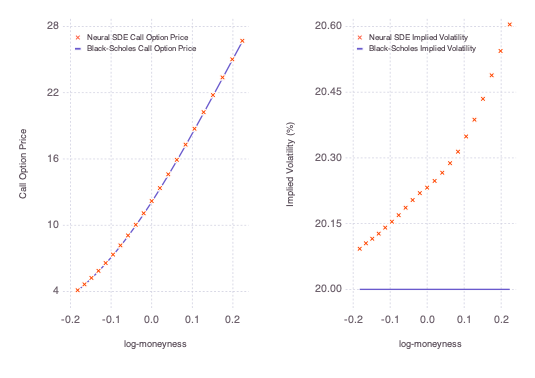

In [552]:
# Plotting call prices
K1 = 100 ./ range(80, 120, length = 21)
K1 = K1[:,1]
log_moneyness = log.(K1)

NSDE_Call_Prices = NSDE_Price[1,:];
BS_Call_Prices = BS_Price[1,:];
NSDE_Call_Vol = Vol_After[1,:].*100;
BS_Call_Vol = BS_Vol[1,:].*100;

layer7 = layer(x= log_moneyness, y=NSDE_Call_Prices,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=BS_Call_Prices,Geom.line,Theme(line_width = 1pt,default_color=colorant"#6A5ACD"))
p5 = Gadfly.plot(layer7,layer8,Guide.yticks(ticks = [ 4    10    16    22    28]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Call Option Price"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Call Option Price","Black-Scholes Call Option Price"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=3, ymax=28))


layer9 = layer(x=log_moneyness, y= NSDE_Call_Vol,Geom.point, shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=BS_Call_Vol, Geom.line,Theme(line_width = 1pt,default_color=colorant"#6A5ACD"))
p6 = Gadfly.plot(layer8,layer9,Guide.yticks(ticks = [20.00   20.15   20.30   20.45   20.60]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Implied Volatility (%)"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Implied Volatility","Black-Scholes Implied Volatility"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=19.97, ymax=20.6))#draw(PDF("myplot20.pdf", 14cm, 7cm), plt)
plt = hstack(p5,p6)
#draw(PDF("myplot15.pdf", 14cm, 7cm), plt)

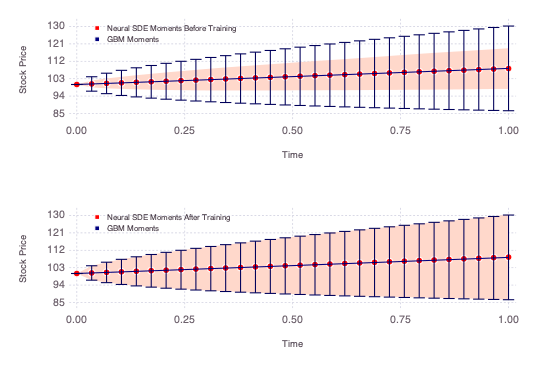

In [553]:
# Plotting moments

layer1 = layer(x = tsteps , y = GBM_Means, ymin= GBM_Means-sqrt.(GBM_Vars), ymax= GBM_Means+sqrt.(GBM_Vars),Geom.errorbar , Geom.line,Theme(line_width = 0.8pt,default_color=colorant"#000080"))  
layer2 = layer(x = tsteps , y = m_before,ymin=m_before-sqrt.(v_before) , ymax= m_before+sqrt.(v_before), Geom.point, Geom.ribbon,Theme(line_width = 1pt,default_color=colorant"#FF0000"))
p1 = Gadfly.plot(layer1,layer2,Guide.ylabel("Stock Price"),Guide.yticks(ticks = [85    94   103   112   121   130]),Guide.xticks(ticks = [0.0 0.25 0.5 0.75 1.0]), Guide.xlabel("Time"),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.manual_color_key("", ["Neural SDE Moments Before Training","GBM Moments"],["#FF0000","#000080"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.square,Gadfly.Shape.square]),Coord.cartesian(xmin=0, xmax=1, ymin=85, ymax=130)) 

layer3 = layer(x = tsteps , y = GBM_Means, ymin= GBM_Means-sqrt.(GBM_Vars), ymax= GBM_Means+sqrt.(GBM_Vars),Geom.errorbar , Geom.line,Theme(line_width = 0.8pt,default_color=colorant"#000080"))  
layer4 = layer(x = tsteps , y = means,ymin=means - sqrt.(vars) , ymax= means + sqrt.(vars), Geom.point, Geom.ribbon,Theme(line_width = 1pt,default_color=colorant"#FF0000"))
p2 = Gadfly.plot(layer3,layer4,Guide.ylabel("Stock Price"),Guide.yticks(ticks = [85    94   103   112   121   130]),Guide.xticks(ticks = [0.0 0.25 0.5 0.75 1.0]), Guide.xlabel("Time"),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.manual_color_key("", ["Neural SDE Moments After Training","GBM Moments"],["#FF0000","#000080"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.square,Gadfly.Shape.square]),Coord.cartesian(xmin=0, xmax=1, ymin=85, ymax=130))


plt = vstack(p1,p2)
#draw(PDF("myplot16.pdf", 14cm, 10cm), plt)